In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import util

In [3]:
dir_data = Path('/Users/josh/Documents/Harvard/GLM/sabatinilab-glm/data/old-data-version/raw-new/Figure_1_2')
dir_output = Path('/Users/josh/Desktop/example_output_folder')

lst_dict_inputdata = [
    {'session_id': 'WT63_11082021',
    'filepath_signal': dir_data / Path('GLM_SIGNALS_WT69_12192021.txt'),
    'filepath_trial': dir_data / Path('GLM_TABLE_WT69_12192021.txt'),
    'bool_trialTable_matlab_indexed': True,
    'columnName_trialTable_trialId': None,
    'columnRenames_signal': {'Ch1': 'gDA', 'Ch5': 'gACH'},
    'columnRenames_trial': {
        'photometryCenterInIndex': 'CI',
        'photometryCenterOutIndex': 'CO',
        'photometrySideInIndex': 'SI',
        'photometrySideOutIndex': 'SO',
        'hasAllPhotometryData': 'hasData'
    }},
]

def construct_lick(df, signal_left_lick_col, signal_right_lick_col):
    return (df[signal_left_lick_col] + df[signal_right_lick_col]).values

def construct_signal_entry(df, signal_left_in_col, signal_right_in_col):
    return (df[signal_left_in_col] + df[signal_right_in_col]).values

# def construct_SEnt(df, signal_entry_col, trial_entry_col):
#     return (df[signal_entry_col] - df[trial_entry_col]).values

dir_output.mkdir(parents=True, exist_ok=True)

columnName_alignment_trial_start = 'CI'
columnName_alignment_trial_end = 'SO'
trial_index_columns = ['CI', 'CO', 'SI', 'SO',]
trial_num_columns = ['nTrial', 'hasData',]
trial_cat_columns = ['wasRewarded', 'word',]
signal_dense_columns = ['gDA', 'gACH',]
signal_sparse_columns = ['lick', 'sideIn']

In [4]:
for dict_inputdata in lst_dict_inputdata:
    df_signal = pd.read_csv(dict_inputdata['filepath_signal']).rename(dict_inputdata['columnRenames_signal'], axis=1)
    df_trial = pd.read_csv(dict_inputdata['filepath_trial']).rename(dict_inputdata['columnRenames_trial'], axis=1)
    
    df_trial['nTrial'] = np.arange(df_trial.shape[0])
    df_signal['lick'] = construct_lick(df_signal, 'leftLick', 'rightLick')
    df_signal['sideIn'] = construct_signal_entry(df_signal, 'rightIn', 'leftIn')

    nrows = df_signal.shape[0]
    
    df_trial = df_trial[(df_trial[trial_index_columns] == 0).sum(axis=1) == 0]
    df_trial_indices = df_trial[trial_index_columns]
    
    matrix_signal_sparse = util.Matrix.from_pd_dense_num(df_signal[signal_sparse_columns]).one_hots_to_inx()
    matrix_signal_dense = util.Matrix.from_pd_dense_num(df_signal[signal_dense_columns])
    matrix_trial_inx = util.Matrix.from_pd_sparse_num(nrows, indices=df_trial_indices - 1, values=None, sparse_value=0)
    matrix_trial_num = util.Matrix.from_pd_sparse_num(nrows, indices=df_trial_indices - 1, values=df_trial[trial_num_columns], sparse_value=np.nan)
    matrix_trial_cat = util.Matrix.from_pd_sparse_cat(nrows, indices=df_trial_indices - 1, values=df_trial[trial_cat_columns], sparse_value=np.nan)
    
    matrix_all_preds = util.Matrix([matrix_signal_sparse, matrix_signal_dense, matrix_trial_inx, matrix_trial_num, matrix_trial_cat])

    # # print(matrix_all_preds.vectors['centerOcc'])

    
    # mtc = matrix_trial_cat.to_pd()['nTrial']
    # display(mtc[(~mtc.isna()).sum(axis=1) > 0])
    # # display(matrix_trial_cat.to_pd()['nTrial'])
    # display(matrix_trial_inx.to_pd())

In [5]:
util.Matrix.from_pd_sparse_cat(nrows, indices=df_trial_indices - 1, values=df_trial[trial_cat_columns], sparse_value=np.nan)

Matrix(vectors={(('wasRewarded', 0), ('CI',)): VectorSparse(name=('wasRewarded', 0), nrows=29850, values=None, indices=[ 1926  2050  2087  2314  2438  2560  2600  2789  3231  3648  4000  4048
  4100  5096  5189  5293  5514  5609  5816  6125  7728  8459  8749  8827
  9389  9833 10430 10960 11047 11173 11514 11610 11696 11785 11834 11870
 12027 12089 12388 12688 12775 12814 12855 13078 13120 13599 13737 13775
 13814 13857 13895 13994 14055 14299 14362 14579 14948 15336 15815 15942
 16077 16229 16950 17302 17379 17420 17457 17509 17547 18192 18236 18538
 18767 18847 18886 19268 19638 21588 21688 22147 22741 22837 22962 23522
 23560 23598 23720 23960 24310 25217 25764 29024], sparse_value=nan, filter_names={'CI'}), (('wasRewarded', 1), ('CI',)): VectorSparse(name=('wasRewarded', 1), nrows=29850, values=None, indices=[ 1222  1290  1450  1507  1565  1655  1725  1783  1866  1971  2124  2179
  2232  2379  2645  2837  2893  2956  3037  3105  3177  3270  3345  3406
  3477  3533  3590  3695  3752

In [6]:
df_signal = pd.read_csv(dict_inputdata['filepath_signal']).rename(dict_inputdata['columnRenames_signal'], axis=1)
df_trial = pd.read_csv(dict_inputdata['filepath_trial']).rename(dict_inputdata['columnRenames_trial'], axis=1)

df_trial['nTrial'] = np.arange(df_trial.shape[0])
df_signal['lick'] = construct_lick(df_signal, 'leftLick', 'rightLick')
df_signal['sideIn'] = construct_signal_entry(df_signal, 'rightIn', 'leftIn')

nrows = df_signal.shape[0]

df_trial = df_trial[(df_trial[trial_index_columns] == 0).sum(axis=1) == 0]
df_trial_indices = df_trial[trial_index_columns]

matrix_signal_sparse = util.Matrix.from_pd_dense_num(df_signal[signal_sparse_columns]).one_hots_to_inx()
matrix_signal_dense = util.Matrix.from_pd_dense_num(df_signal[signal_dense_columns])
matrix_trial_inx = util.Matrix.from_pd_sparse_num(nrows, indices=df_trial_indices - 1, values=None, sparse_value=0)
matrix_trial_num = util.Matrix.from_pd_sparse_num(nrows, indices=df_trial_indices - 1, values=df_trial[trial_num_columns], sparse_value=np.nan)
matrix_trial_cat = util.Matrix.from_pd_sparse_cat(nrows, indices=df_trial_indices - 1, values=df_trial[trial_cat_columns], sparse_value=np.nan)
matrix_all_preds = util.Matrix([matrix_signal_sparse, matrix_signal_dense, matrix_trial_inx, matrix_trial_num, matrix_trial_cat])

In [7]:
matrix_all_preds.to_pd().columns

MultiIndex([(                '',   'lick'),
            (                '', 'sideIn'),
            (             'gDA',       ''),
            (            'gACH',       ''),
            (                '',     'CI'),
            (                '',     'CO'),
            (                '',     'SI'),
            (                '',     'SO'),
            (          'nTrial',     'CI'),
            (         'hasData',     'CI'),
            (          'nTrial',     'CO'),
            (         'hasData',     'CO'),
            (          'nTrial',     'SI'),
            (         'hasData',     'SI'),
            (          'nTrial',     'SO'),
            (         'hasData',     'SO'),
            (('wasRewarded', 0),     'CI'),
            (('wasRewarded', 1),     'CI'),
            (    ('word', 'AA'),     'CI'),
            (    ('word', 'AB'),     'CI'),
            (    ('word', 'Aa'),     'CI'),
            (    ('word', 'Ab'),     'CI'),
            (    ('word', 'aA'),

In [8]:
CI = matrix_all_preds[('', 'CI')]
CO = matrix_all_preds[('', 'CO')]
SI = matrix_all_preds[('', 'SI')]
SO = matrix_all_preds[('', 'SO')]
lick = matrix_all_preds[('', 'lick')]
SEnt = (matrix_all_preds[('', 'sideIn')]&~matrix_all_preds[('', 'SI')])
SI_rew = matrix_all_preds[('wasRewarded', 'SI')]
SI_wd = matrix_all_preds[('word', 'SI')]

gDA = matrix_all_preds['gDA']
gACH = matrix_all_preds['gACH']

In [9]:
lst_rewards = [
    CI,
    CO,
    SO,
    lick,
    SEnt,
    SI_rew
]
[reward.set_sparse_value(0.0) for reward in lst_rewards];
lst_words = [
    CI,
    CO,
    SO,
    lick,
    SEnt,
    SI_wd
]
[word.set_sparse_value(0.0) for word in lst_words];

In [10]:
X_reward = util.Matrix(lst_rewards).shift(range(-20, 21))
X_words = util.Matrix(lst_words).shift(range(-20, 21))

y_gDA = gDA
y_gACH = gACH

In [11]:
df_X_reward = X_reward.to_pd().sort_index(axis=1)
df_X_words = X_words.to_pd().sort_index(axis=1)
srs_y_gDA = y_gDA.to_pd()
srs_y_gACH = y_gACH.to_pd()

In [12]:
keep_rows_reward = df_X_reward.isna().sum(axis=1) == 0
keep_rows_words = df_X_words.isna().sum(axis=1) == 0

df_X_reward_keep = df_X_reward[keep_rows_reward.values]
srs_y_gDA_keep = srs_y_gDA[keep_rows_reward.values]
df_X_words_keep = df_X_words[keep_rows_words.values]
srs_y_gDA_keep = srs_y_gDA[keep_rows_words.values]

# with pd.option_context('display.max_columns', None):
#     display(df_X_reward_keep)
#     display(df_X_words_keep)

<Axes: >

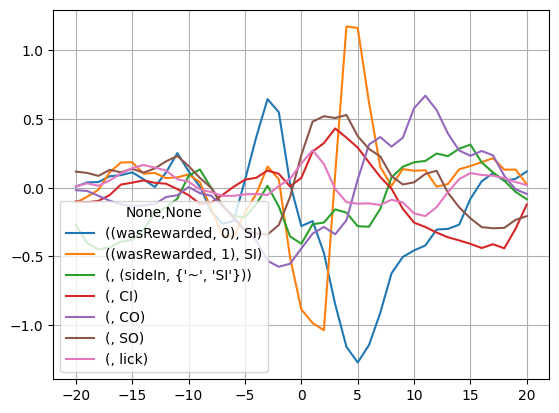

In [13]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=False)
lr.fit(df_X_reward_keep, srs_y_gDA_keep)
pd.Series({a:b for a,b in zip(df_X_reward_keep.columns, lr.coef_)}).unstack().T.plot(grid=True)

<Axes: >

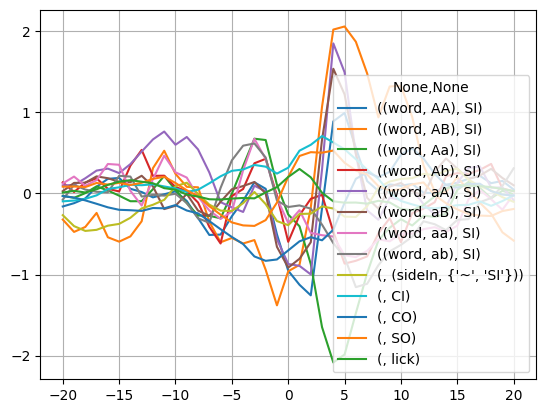

In [18]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=False)
lr.fit(df_X_words_keep, srs_y_gDA_keep)
pd.Series({a:b for a,b in zip(df_X_words_keep.columns, lr.coef_)}).unstack().T.plot(grid=True)